# Can we predict whether a hotel booking would be canceled?

## Goal: 
- Using hotel booking and cancellation data, we can predict if a certain booking is likely to get cancelled. 
 

### Data that will be used in this analysis: 
Importing hotel cancellation data sourced from Kaggle- 
https://www.kaggle.com/datasets/arezaei81/hotel-bookingcvs/data

High level data description: Data contains
-	Details of a reservation (lead time, dates, status, etc,)
-	Information on the booking party, such as number of kids, previous cancellation history
-	Information on the hotel, property type

### The techniques I expect to use in my analysis
1. Exploratory data analysis
2. Feature engineering/data cleanup
3. Machine learning models for classification such as random forest, decisions trees.

### The expected results
- Analysis to predict if a certain booking will get cancelled
- We can also predict how long after the booking or how far in advance of the reservation date does cancellation typically occurs

### Why this question is important
1. Hotel cancellations, commensurate with travel boom, skyrocketed from 2019 to 2022. We experienced about 15% cancellations in 2019, which was up to 20% in 2022. An almost 33% increase. With the economic slowdown being what it is, this sort of prediction model can help hotel with revenue planning, staffing, and other operational planning.
2. Hotels can also use this pattern to inform their cancellation policies. 

### Structure of the code
1. Data assembly and preparation
2. Feature Engineering
3. Data visualization
4. Modeling: a. Decision Tree, b. Random forest

## 1. Data assembly and preparation


In [316]:
#importing the necessary libraries

import numpy as np
import pandas as pd 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [317]:
# reading data from data acquired from kaggle
hotel_initial = pd.read_csv('data/hotel_booking.csv')

In [318]:
# take a look at the  data
hotel_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [319]:
# performing some group bys to get a better sense of data
hotel_initial.groupby('customer_type').size().reset_index(name='count')

,customer_type,count
0,Contract,4076
1,Group,577
2,Transient,89613
3,Transient-Party,25124


### Data characteristics

1. 119,930 observations
2. Reservation characteristics:

- is_canceled: Indicator showing if the reservation was cancelled
- lead_time: time between reservation made and expected check-in date
- arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month: Arrival date data
- stays_in_weekend_nights, stays_in_week_nights: duration of the reservations
- adults, children, babies: guest counts
- meal, required_car_parking_spaces, total_of_special_requests: Reservation characteristics
- country: country of the reserving party
- market_segment: market segment representing the booking party
- distribution_channel: where the reservations is coming from e.g. direct, or travel agents, or other distribution channels
- is_repeated_guest, previous_cancellations, previous_bookings_not_canceled: Guest history
- reserved_room_type, assigned_room_type, deposit_type: reservations characteristics
- booking_changes: how many times this booking was changed?
- agent: in case where the booking came in via an agent, this indicates which agent
- days_in_waiting_list: days the customer had to be in a waiting list
- customer_type: whether it was a group or individual or transient group booking
- adr: average daily rate
- reservation_status, reservation_status_date: what was the outcome of the reservation


In [320]:
hotel_initial.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015


#### Initial data observation
Data is in pretty good shape with very few missing values. 

<b>Steps needs for intial data set up </b>
1. Get statistical  info on the data
2. Address missing values
3. Identify outlier
4. Encode categorical variables like reservation status

In [321]:
hotel_initial.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


### Data stats
1. Most columns seem to have no outliers or incorrect values
- is_canceled: Data suggests 37% of the reservations were canceled. 
- Only 3% were repeated_guests
- Missing values are in columns: children, agent, company
     
2. Potential outliers or data entry errors:
- Lead time of 2 years (737 max) 
- 50 days of stay in week nights and 19 days of stay in weekend nights
- Booking containing high # of guests e.g. 55 adults, 10 children and/or 10 babies
- Adr: negative ADR is incorrect data and needs to be addressed
- minimum of adults is 0 which is extremely rare. Need to confirm if the data isn't erroneously entered. 

3. Patterns:
- lead_time: With average being 104 days, it appears 3 months before travel data is when reservations are typically made. 
- arrival_date_week_number: Median is 28th week which makes sense because it's summer time
- stays_in_week_nights: guests stay for about 2.5 week nights

In [322]:
# Get the summary statistics for categorical variables

# listing the categorical columns
categorical_columns_list = [
    'hotel',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
    'credit_card'
]

# Convert to string data type
for column in categorical_columns_list:
    if column in hotel_initial.columns:
        hotel_initial[column] = hotel_initial[column].astype(str)

# confirm data types
hotel_initial.dtypes
hotel_initial.describe(include='object').T

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
arrival_date_month,119390,12,August,13877
meal,119390,5,BB,92310
country,119390,178,PRT,48590
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870
reserved_room_type,119390,10,A,85994
assigned_room_type,119390,12,A,74053
deposit_type,119390,3,No Deposit,104641
agent,119390,334,9.0,31961


### Observations from categorical variables:
1. Hotel: 65% of the hotels are city hotels
2. meal: 5 unique types of meals with the most common type being "BB"
3. country: 178 unique countries of origin. Interensting, most common is "PRT" (Portugal)
4. market_segment: Eight unique market segments, Online TA is the most common
5. distribution_channel: Five unique booking distribution channels, "TA/TO" most common
6. deposit_type: "No deposit" observed ~104,000 times. 2 other types present. 

#### Address missing values
1. imputate 0 for children
2. No action on missing agent or company values

In [323]:
hotel_initial['children'] = hotel_initial['children'].fillna(0)

In [324]:
hotel_initial['country'] = hotel_initial['country'].fillna(0)

### Find outliers

In [325]:
# lead time
Q1 = hotel_initial['lead_time'].quantile(0.25)
Q3 = hotel_initial['lead_time'].quantile(0.75)
IQR = Q3 - Q1
outliers=(hotel_initial['lead_time'] < (Q1 - 3 * IQR)) | (hotel_initial['lead_time'] > (Q3 + 3 * IQR))

# Print the values of outliers
outlier_values = [hotel_initial['lead_time'][i] for i in range(len(hotel_initial['lead_time'])) if outliers[i]]
print("Maximum value among outliers:", max(outlier_values))
print("Minimum value among outliers:", min(outlier_values))
#print("Outliers:", outlier_values)


Maximum value among outliers: 737
Minimum value among outliers: 587


#### Lead time: At this time, it does not seem pertinent to remove these outliers. We will see if it causes any problems in our model and address it later, if needed.

In [326]:
#50 days of stay in week nights and 19 days of stay in weekend nights
#addresing week nights stay that are too high 
hotel_initial.nlargest(5, 'stays_in_week_nights')
hotel_initial.nlargest(5, 'stays_in_weekend_nights')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
14038,Resort Hotel,0,126,2016,July,28,5,19,50,1,...,No Deposit,nan,nan,0,Transient,110.00,0,3,Check-Out,9/12/2016
14037,Resort Hotel,0,113,2015,August,31,1,18,42,1,...,No Deposit,nan,nan,0,Transient,110.50,0,3,Check-Out,9/30/2015
9839,Resort Hotel,1,322,2017,January,2,10,16,40,2,...,No Deposit,8.0,nan,0,Transient,25.50,0,0,Canceled,10/31/2016
33924,Resort Hotel,0,71,2017,January,2,10,16,40,2,...,No Deposit,196.0,nan,0,Transient,28.79,0,0,Check-Out,3/7/2017
101794,City Hotel,0,140,2016,September,39,22,16,41,0,...,No Deposit,9.0,nan,0,Transient,8.34,0,2,Check-Out,11/18/2016


### Unusual values: adr, # of adults, children, babies

In [327]:
unusual_Records = {
    'adr':      hotel_initial[hotel_initial['adr'] < 0],
    'adults':   hotel_initial[hotel_initial['adults'] == 0],
    'children': hotel_initial[hotel_initial['children'] == 10],
    'babies':   hotel_initial[hotel_initial['babies'] == 10],
}

unusual_Records = {key: len(value) for key, value in unusual_Records.items()}
unusual_Records

{'adr': 1, 'adults': 403, 'children': 1, 'babies': 1}

#### Only 1 record for all of these unusual values. We will remove the record.

In [328]:
unusual_Records = {
    'adr':      hotel_initial[hotel_initial['adr'] == 0]
}

unusual_Records = {key: len(value) for key, value in unusual_Records.items()}
unusual_Records

{'adr': 1959}

1959 records ahve $0 adr. We do not have enough context to know if these are promotional rates or error. To err on the side of caution, and because our data size is quite large, we will remove these.

In [329]:
hotel_initial.drop(hotel_initial[hotel_initial['adr'] <= 0].index, inplace=True)

#### The high number of weekend and weeknight stays coincide, indicating that these are not errors.


## 2. Feature Engineering

### Actions to be taken in this section:
1. Remove features that can cause 'data leakage'
2. Add features that can improve our analysis
3. Removing features irrelevant to our analysis
4. label or one-hot encoding for features

In [330]:
#is_canceled is directly related to reservation_status
hotel_initial.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000,117430.000000
mean,0.374785,105.084340,2016.160274,27.136779,15.802819,0.936422,2.521221,1.860632,0.104505,0.007869,0.027872,0.086954,0.125334,0.216486,2.337937,103.530818,0.062642,0.571038
std,0.484069,106.907012,0.706565,13.575680,8.783582,0.995760,1.893742,0.482102,0.399690,0.097168,0.164607,0.848690,1.446204,0.633188,17.677053,49.198721,0.245565,0.791655
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.260000,0.000000,0.000000
25%,0.000000,19.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.530000,0.000000,0.000000
50%,0.000000,71.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000
75%,1.000000,162.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,709.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,4.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,391.000000,5400.000000,8.000000,5.000000


In [331]:
hotel_initial.groupby('reservation_status')['is_canceled'].mean()

reservation_status
Canceled     1.0
Check-Out    0.0
No-Show      1.0
Name: is_canceled, dtype: float64

In [332]:
# Drop the `reservation_status` feature because it is the same as is_Canceld
hotel_initial = hotel_initial.drop(['reservation_status'], axis=1)

### Add features that can improve our analysis

To predict cancellation time, we can find the number of days ahead of the booking the customers cancel their reservations. We will call this feature 'reservation_update'. 
- If reservation_update < 0  = reservation was cancel before the booking date
- If reservation_update >= 0  = updates were made on or after arrival. But these rows won't be relevant to this part of our analysis.

In [333]:
# change 'reservation_status_date' to date format
hotel_initial['reservation_status_date'] = pd.to_datetime(hotel_initial['reservation_status_date'])

# Extract Days_Difference from 'reservation_status_date'
hotel_initial['reservation_update'] = (hotel_initial['reservation_status_date'] - pd.to_datetime(hotel_initial['arrival_date_year'].astype(str) + '-' + hotel_initial['arrival_date_month'] + '-' + hotel_initial['arrival_date_day_of_month'].astype(str))).dt.days

In [334]:
# Create 'is_Family' column
hotel_initial['is_family_kids'] = hotel_initial[['children', 'babies']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

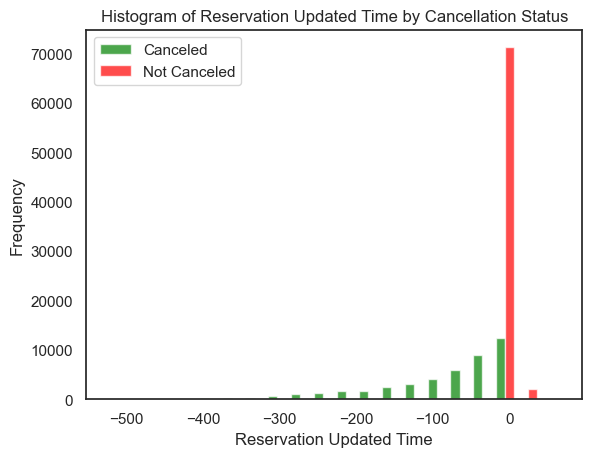

In [335]:
# Create a histogram with colors split by reservation status
plt.hist([hotel_initial[hotel_initial['is_canceled'] == 1]['reservation_update'],
          hotel_initial[hotel_initial['is_canceled'] == 0]['reservation_update']],
         bins=20, color=['green', 'red'], alpha=0.7, label=["Canceled", "Not Canceled"])

# Add labels and title
plt.xlabel('Reservation Updated Time')
plt.ylabel('Frequency')
plt.title('Histogram of Reservation Updated Time by Cancellation Status')

# Add a legend with a title
plt.legend()

# Show the plot
plt.show()

#### It is clear that updated time is negative for canceled bookings.

### Drop features that aren't relevant to our analysis
1. Assigned room type
2. arrival_date_year : as we aren't interested in a time analysis 
3. high cardinality features like country, agent, company

In [336]:
columns_to_drop = ['assigned_room_type', 'arrival_date_year', 'country', 'agent', 'company']
hotel_initial.drop(columns=columns_to_drop, inplace=True)

### One-hot encoding

In [337]:
hotel_initial.dtypes

hotel                                     object
is_canceled                                int64
lead_time                                  int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                 float64
babies                                     int64
meal                                      object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
booking_changes                            int64
deposit_type                              object
days_in_waiting_list

In [338]:
#label coding: change arrival month to
# Mapping dictionary for month names to month numbers
month_name_to_number =  ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Map month names to month numbers
hotel_initial['arrival_date_month'] = hotel_initial['arrival_date_month'].apply(lambda x: month_name_to_number.index(x) + 1)

In [339]:
#categorical features that need one hot coding: hotel, meal, market_segmen, distribution_channel, 
# reserved_room_type, deposit_type, customer_type
# One-hot encode the specified columns
one_hot_cols = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']


# Perform one-hot encoding on the 'Category' column
one_hot_encoded = pd.get_dummies(hotel_initial[one_hot_cols])

# Concatenate the original DataFrame with the one-hot encoded columns
hotel_encoded = pd.concat([hotel_initial, one_hot_encoded], axis=1)

hotel_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117430 entries, 2 to 119389
Data columns (total 64 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           117430 non-null  object        
 1   is_canceled                     117430 non-null  int64         
 2   lead_time                       117430 non-null  int64         
 3   arrival_date_month              117430 non-null  int64         
 4   arrival_date_week_number        117430 non-null  int64         
 5   arrival_date_day_of_month       117430 non-null  int64         
 6   stays_in_weekend_nights         117430 non-null  int64         
 7   stays_in_week_nights            117430 non-null  int64         
 8   adults                          117430 non-null  int64         
 9   children                        117430 non-null  float64       
 10  babies                          117430 non-null  int64  

## 3. Data Visualization

Before we get into modeling of data, we want to see if there are some references we can draw via visualization. 

1. Is adr a factor in cancelations?
2. How does reservation_update vary with the various categorical...? 

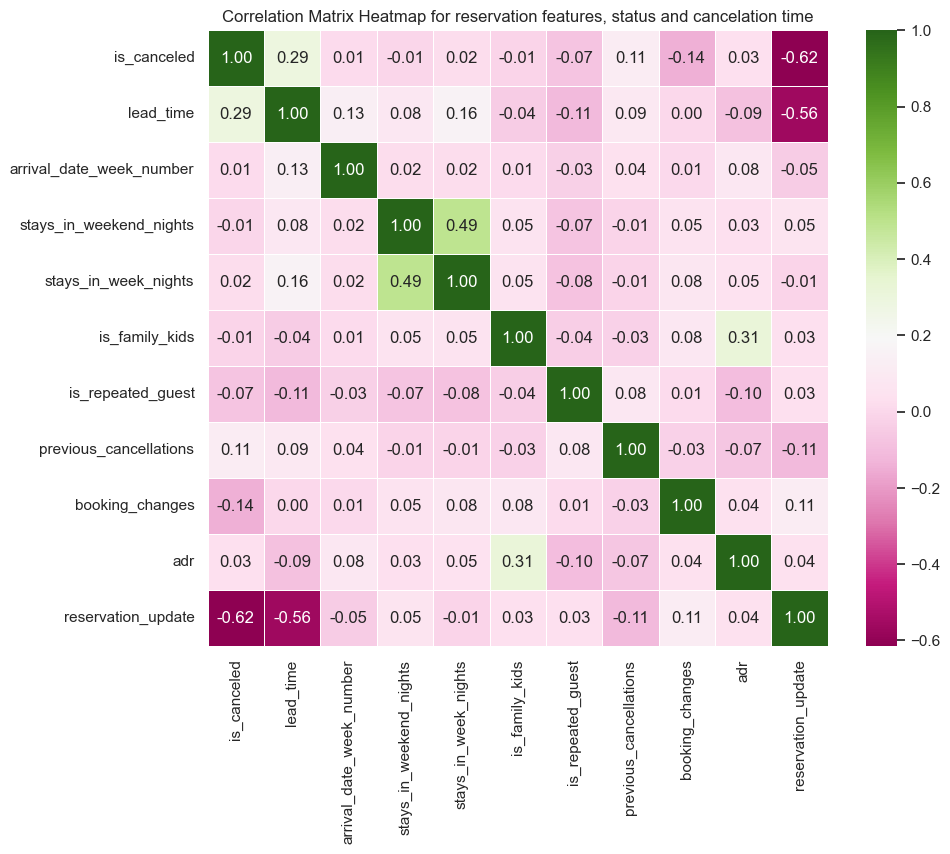

In [340]:
# Create a heatmap using seaborn
#check which of the new features have a correlation with the price
selected_columns = ['is_canceled','lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'is_family_kids',
                    'is_repeated_guest', 'previous_cancellations', 'booking_changes', 'adr', 'reservation_update']
correlation_matrix = hotel_encoded[selected_columns].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='PiYG', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap for reservation features, status and cancelation time')
plt.show()

### Observations:
1. High lead time demonstrates a high correlation with cancelation status and cancelation time (Reservation+update) - implying that earlier the consumers book, higher the chance that that they will cancel. 
2. Parties traveling with kids have a higher adr rate typically and show low cancelation rate. 
3. It doesn't appear that high adr causes a higher likelihood of cancelation. 

### 

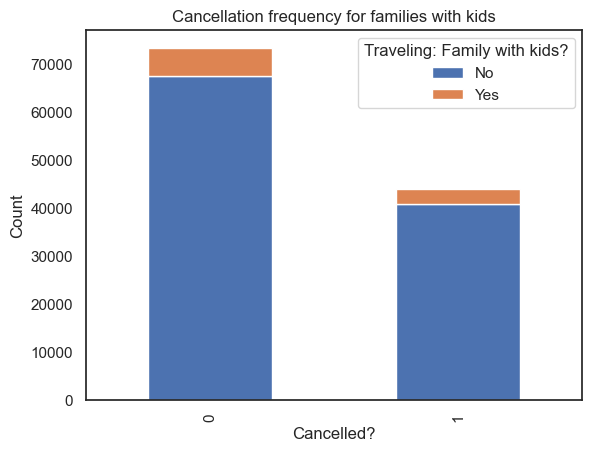

In [341]:
ax=hotel_encoded.groupby(['is_canceled', 'is_family_kids']).size().unstack().plot(kind='bar', stacked=True)
# Add labels and title
plt.xlabel('Cancelled?')
plt.ylabel('Count')
plt.title('Cancellation frequency for families with kids')

# Create a custom legend with a title
legend_title = 'Traveling: Family with kids?'
legend_labels = ['No', 'Yes']  # Replace with your legend labels
ax.legend(legend_labels, title=legend_title)

plt.show()

#### It seems that families with kids tend to cancel less- probably because of associated cost of travel that may not get reimubrsed

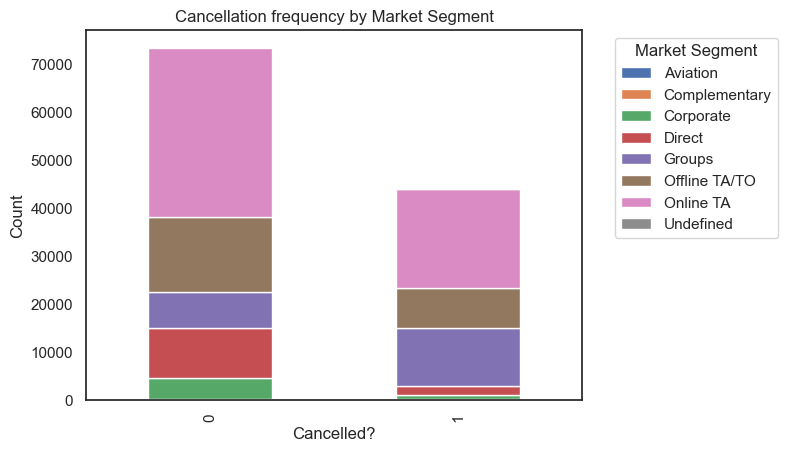

In [342]:
ax=hotel_encoded.groupby(['is_canceled', 'market_segment']).size().unstack().plot(kind='bar', stacked=True)
# Add labels and title
plt.xlabel('Cancelled?')
plt.ylabel('Count')
plt.title('Cancellation frequency by Market Segment')

# Create a custom legend with a title
legend_title = 'Market Segment'

ax.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
plt.show()

#### Observations: 
1. Online TA do account for a significant portion of the bookings AND cancellations
2. Groups reservations seem to get cancelled more than kept - stands to reason because coordination amongst groups could cause cancellations. 

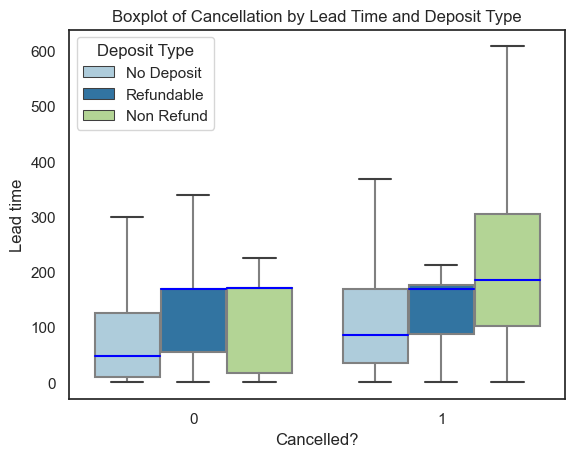

In [343]:
#does lead time or deposit type impact cancellation 
sns.set(style="white")  

palette1 = sns.color_palette("Paired")

# Create a boxplot with 'Category' on the x-axis and 'Price' on the y-axis
whisker_color = 'grey' 
boxprops = {'edgecolor': 'grey'}  # Change 'black' to the desired color
outlier_color = 'grey' 

# Create a boxplot
sns.boxplot(x="is_canceled", y="lead_time", hue='deposit_type',  data=hotel_encoded, palette=palette1,  boxprops=boxprops
           , whiskerprops=dict(color=whisker_color), medianprops=dict(color='blue'),
            flierprops=dict(markerfacecolor=outlier_color, marker='o', markersize=1), showfliers=False)

# Add title to the boxplot
plt.title('Boxplot of Cancellation by Lead Time and Deposit Type')
plt.xlabel('Cancelled?')
plt.ylabel('Lead time')

# Add title to the legend
plt.legend(title="Deposit Type")


# Show the plot
plt.show()

#### Observations:
1. Parties booking non refundable options with small lead time seem less likely to cancel probably because these are booked only after plans have been confirmed
2. Large times still drive up cancelation rates despite of bookings being non-refundable. 

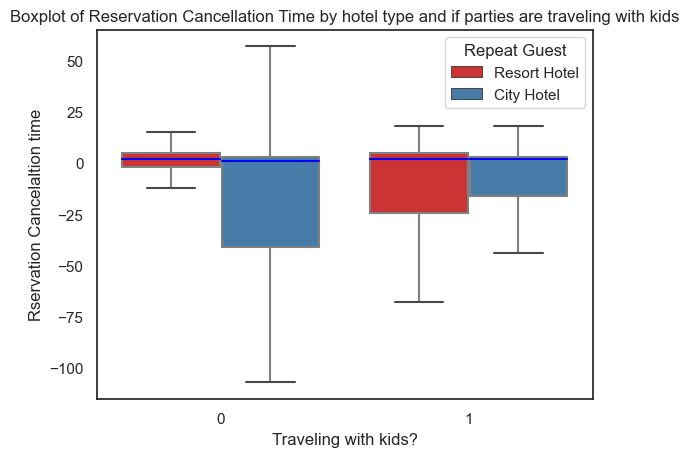

In [344]:
# cancellation time and traveling with kids, hotel type

sns.set(style="white")  

palette1 = sns.color_palette("Set1")

# Create a boxplot with 'Category' on the x-axis and 'Price' on the y-axis
whisker_color = 'grey' 
boxprops = {'edgecolor': 'grey'}  # Change 'black' to the desired color
outlier_color = 'grey' 

# Create a boxplot
sns.boxplot(x="is_family_kids", y="reservation_update", hue='hotel',  data=hotel_encoded, palette=palette1,  boxprops=boxprops
           , whiskerprops=dict(color=whisker_color), medianprops=dict(color='blue'),
            flierprops=dict(markerfacecolor=outlier_color, marker='o', markersize=1), showfliers=False)

# Add title to the boxplot
plt.title('Boxplot of Reservation Cancellation Time by hotel type and if parties are traveling with kids')
plt.xlabel('Traveling with kids?')
plt.ylabel('Rservation Cancelaltion time')

# Add title to the legend
plt.legend(title="Repeat Guest")


# Show the plot
plt.show()

#### Observation:
1. Parties traveling with kids seem to book and cancel resorts more than city hotels.
2. Parties not traveling with kids seem to prefer city hotels, which also showed higher cancelations.

## 4. Modeling

We will use a few models to go through this exercise. 
1. Decision tree


In [345]:
#remove features that shouldn't be included
columns_to_drop = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type'
                  , 'deposit_type', 'customer_type', 'reservation_status_date', 'reservation_update']

hotel_encoded_model=hotel_encoded.drop(columns=columns_to_drop)

In [346]:
# Split the data into features (X) and target variable (y)
X = hotel_encoded_model.drop('is_canceled', axis=1)
y = hotel_encoded_model['is_canceled']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Access feature importances
feature_importances = clf.feature_importances_

# Display feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")
    
# Train the model
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

Accuracy: 0.8247040790258026
lead_time: 0.15552351227266348
arrival_date_month: 0.01901371976851478
arrival_date_week_number: 0.06158507657309628
arrival_date_day_of_month: 0.08068175554538672
stays_in_weekend_nights: 0.02498822494724475
stays_in_week_nights: 0.04499472591295781
adults: 0.01366796263834455
children: 0.003502994281133886
babies: 0.0007868753582606631
is_repeated_guest: 0.0005482784985102241
previous_cancellations: 0.0332061710165128
previous_bookings_not_canceled: 0.0063708526318731595
booking_changes: 0.015513059685679368
days_in_waiting_list: 0.0016123505663045922
adr: 0.10807705959083552
required_car_parking_spaces: 0.01888149729384423
total_of_special_requests: 0.05674940961284049
is_family_kids: 0.002099349437067565
hotel_City Hotel: 0.006193501087206991
hotel_Resort Hotel: 0.0019590517966036245
meal_BB: 0.004451372081467431
meal_FB: 0.0017473547153761836
meal_HB: 0.004043781922924447
meal_SC: 0.002563341401089533
meal_Undefined: 0.0008993461444713319
market_segmen

### Observations:

#### Features with high importance:
1. Lead time: Agreeing with our observations thus far (0.15552351227266348)
2. adr: Highers the adr, higher the change of cancelation (0.10807705959083552)
3. Non refund deposit: This did feature has an important one. However, this could also be because most hotels may not offer refundable options, or could be more expensive. 
4. Total number of special requests: The 4th important feature - the more special requests a customer may have, the more chance that they may cancel the booking if any of those aren't met (e.g. early check in, crib for a child, etc.)

#### Evaluation:

Given that we are trying predict for a cancellation, precision seems like a better metric. If a hotel acts on the prediction and doesn't staff for it or overbooks the hotel, there can be significant consequences to hotel reviews and reputation if the party does show up.

Precision from this model is 0.767, which isn't bad. But we probably want something higher tha  0.8 for customer churn/cancelation type situations.

In [350]:
# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define hyperparameter grid for Grid Search
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.8270033211274802
Precision: 0.8285163776493256


#### Observations:
With a depth of 15 or under with at least 2 splits, we are able to achieve our desired precision of 0.8285. (> 0.8 which is desired for customer cancellation situations.

In [348]:
## model evaluation
# Perform 5-fold cross-validation
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

# Train the model on the entire training set
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy}")

Cross-Validation Scores: [0.81121933 0.81324179 0.8146788  0.81531747 0.81434958]
Mean Accuracy: 0.8137613960251725
Accuracy on Test Set: 0.8247040790258026


#### Observation:
Cross validation doesn't yield answers too different than the original model, indiciating that the model isn't biased in the sampled data.

In [349]:
## random forest
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8622583666865367
Precision: 0.8665270871499607
Recall: 0.7493493266945797
F1 Score: 0.8036895442684628


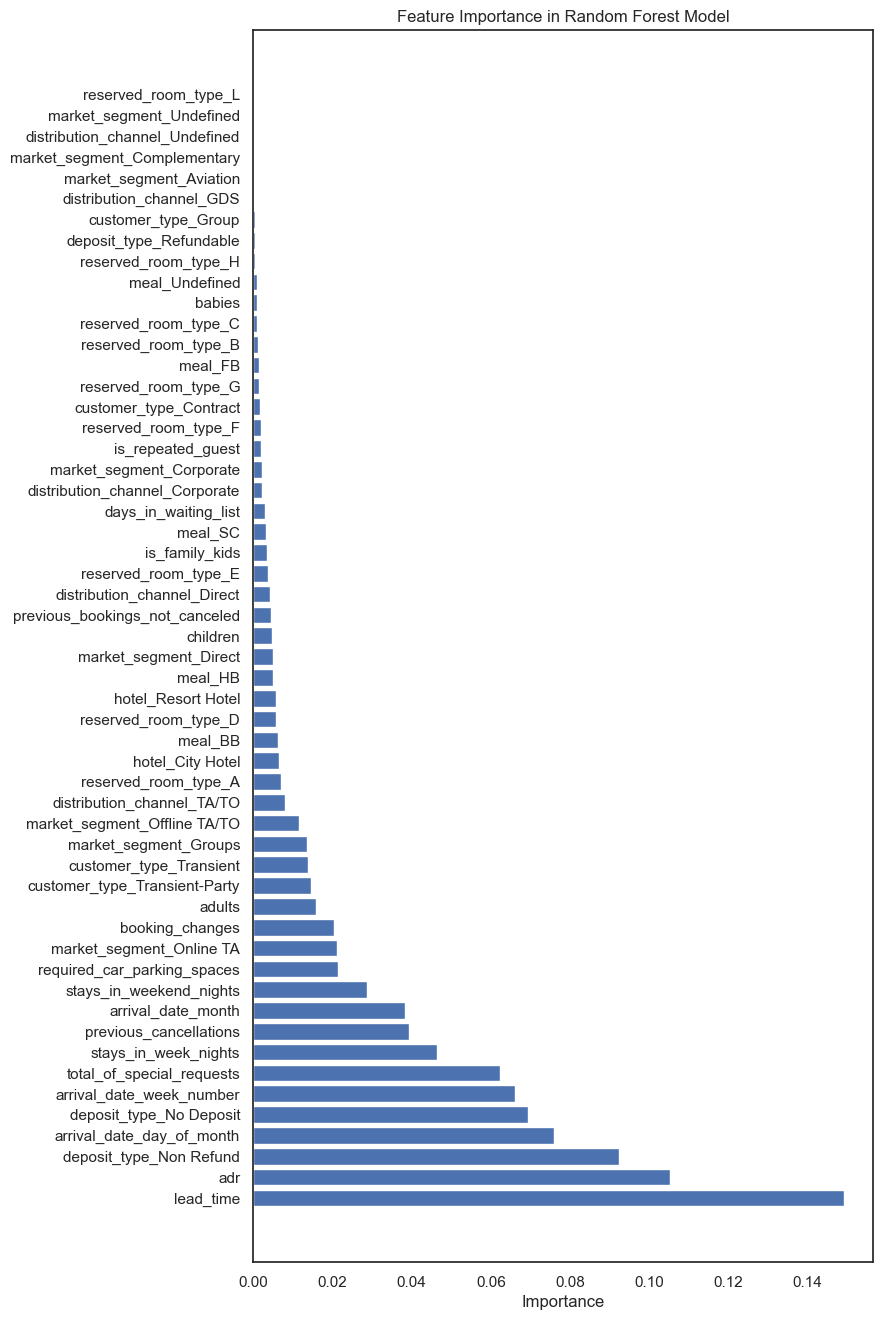

In [354]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 16))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()

#### Observation:
Right off the bat, random forest is giving us better precision than decision tree (0.867 compared 0.83 from a hypertuned model).
The most important features are:
1. Lead time
2. Average daily rate
3. Non refundable deposit
A new one that featured here higher was: arrival_Date_day_of_month- indicating that the arrivals towards end of the month are more likely to result in cancellations.

### For parties that do cancel, what is the average time before arrival that they cancel?

In [362]:
#limit our data to just cancelled
hotel_cancel = hotel_encoded[hotel_encoded['is_canceled'] == 1]

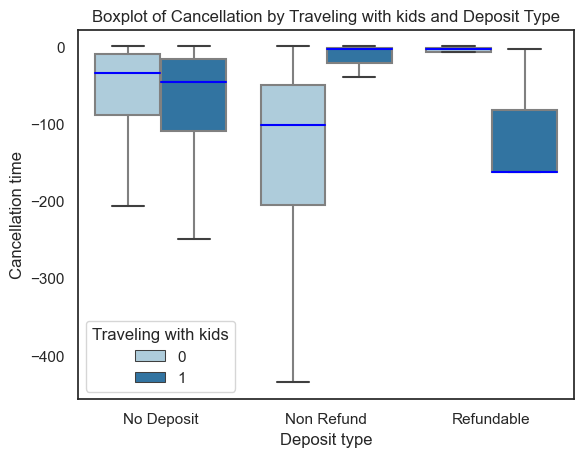

In [368]:
# compare with is_family_kids, hotel type

sns.set(style="white")  

palette1 = sns.color_palette("Paired")

# Create a boxplot with 'Category' on the x-axis and 'Price' on the y-axis
whisker_color = 'grey' 
boxprops = {'edgecolor': 'grey'}  # Change 'black' to the desired color
outlier_color = 'grey' 

# Create a boxplot
sns.boxplot(x="deposit_type", y="reservation_update", hue='is_family_kids',  data=hotel_cancel, palette=palette1,  boxprops=boxprops
           , whiskerprops=dict(color=whisker_color), medianprops=dict(color='blue'),
            flierprops=dict(markerfacecolor=outlier_color, marker='o', markersize=1), showfliers=False)

# Add title to the boxplot
plt.title('Boxplot of Cancellation by Traveling with kids and Deposit Type')
plt.xlabel('Deposit type')
plt.ylabel('Cancellation time')

# Add title to the legend
plt.legend(title="Traveling with kids")


# Show the plot
plt.show()

#### Observation: 
It does seem that average time to cancel can vary by characteristics. e.g. here we see that families traveling with kids will cancel very close to the arrival time (probably as a last resort). We can guess that's because having spent money in the reservation, they feel invested to travel and not waste the money. People not traveling with kids seem to have more flexibility.

# Conclusion
1. List features 
2. List model